In [2]:
# 1. IMPORT NECESSARY LIBRARIES:

import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [3]:
# 2. IMPORT DATASET:
ipl = pd.read_csv('E:/Machine Learning/Machine Learning/Machine_Learning_Projects/Machine_Learning_Projects/1. IPL Score Prediction/ipl_data.csv')

In [4]:
# 3. DATA PRE-PROCESSING:
# 3.1 Drop unnecessary columns
df = ipl.drop(['date', 'runs', 'wickets', 'overs', 'runs_last_5', 'wickets_last_5','mid', 'striker', 'non-striker'], axis=1)

In [5]:
# 3.2 Define the x (independent variable) and y (dependent variable)
x = df.drop(['total'], axis=1)
y = df['total']

In [6]:
# 3.3 Label Encoding
venue_encoder = LabelEncoder()
bat_team_encoder = LabelEncoder()
bowl_team_encoder = LabelEncoder()
batsman_encoder = LabelEncoder()
bowler_encoder = LabelEncoder()

x['venue'] = venue_encoder.fit_transform(x['venue'])
x['bat_team'] = bat_team_encoder.fit_transform(x['bat_team'])
x['bowl_team'] = bowl_team_encoder.fit_transform(x['bowl_team'])
x['batsman'] = batsman_encoder.fit_transform(x['batsman'])
x['bowler'] = bowler_encoder.fit_transform(x['bowler'])

In [7]:
# 3.4 Train-Test Split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [8]:
# 3.5 Feature Scaling
scaler = MinMaxScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [9]:
# 4. CONVERT DATA TO PYTORCH TENSORS:
# # 4.1 Convert to PyTorch tensors
x_train_tensor = torch.tensor(x_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
x_test_tensor = torch.tensor(x_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

In [10]:
# 4.2 Create DataLoader
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [11]:
# 5. DEFINE THE NEURAL NETWORK
class IPLScorePredictor(nn.Module):
    def __init__(self):
        super(IPLScorePredictor, self).__init__()
        self.fc1 = nn.Linear(x_train_tensor.shape[1], 512)
        self.fc2 = nn.Linear(512, 216)
        self.fc3 = nn.Linear(216, 1)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = IPLScorePredictor()

In [12]:
# 6. COMPILING THE MODEL.
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.HuberLoss()  # equivalent to 'huber' loss in Keras

In [13]:
# 7. MODEL TRAINING
num_epochs = 50
train_losses = []
val_losses = []

In [14]:
# 7.1 Train the model
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for xb, yb in test_loader:
            preds = model(xb)
            loss = criterion(preds, yb)
            val_loss += loss.item()
    
    val_loss /= len(test_loader)
    val_losses.append(val_loss)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

Epoch 1/50, Train Loss: 31.1917, Val Loss: 22.3681
Epoch 2/50, Train Loss: 22.2070, Val Loss: 21.8385
Epoch 3/50, Train Loss: 22.0876, Val Loss: 21.7440
Epoch 4/50, Train Loss: 21.9304, Val Loss: 21.5595
Epoch 5/50, Train Loss: 21.7475, Val Loss: 21.5414
Epoch 6/50, Train Loss: 21.6206, Val Loss: 21.6325
Epoch 7/50, Train Loss: 21.4665, Val Loss: 21.6760
Epoch 8/50, Train Loss: 21.3714, Val Loss: 21.1784
Epoch 9/50, Train Loss: 21.2495, Val Loss: 20.8828
Epoch 10/50, Train Loss: 21.1278, Val Loss: 20.8643
Epoch 11/50, Train Loss: 21.0116, Val Loss: 20.6580
Epoch 12/50, Train Loss: 20.9051, Val Loss: 20.7970
Epoch 13/50, Train Loss: 20.7540, Val Loss: 20.5085
Epoch 14/50, Train Loss: 20.7133, Val Loss: 20.3740
Epoch 15/50, Train Loss: 20.5841, Val Loss: 20.5861
Epoch 16/50, Train Loss: 20.5183, Val Loss: 20.3897
Epoch 17/50, Train Loss: 20.3604, Val Loss: 20.2045
Epoch 18/50, Train Loss: 20.2896, Val Loss: 20.6962
Epoch 19/50, Train Loss: 20.1702, Val Loss: 19.9634
Epoch 20/50, Train Lo

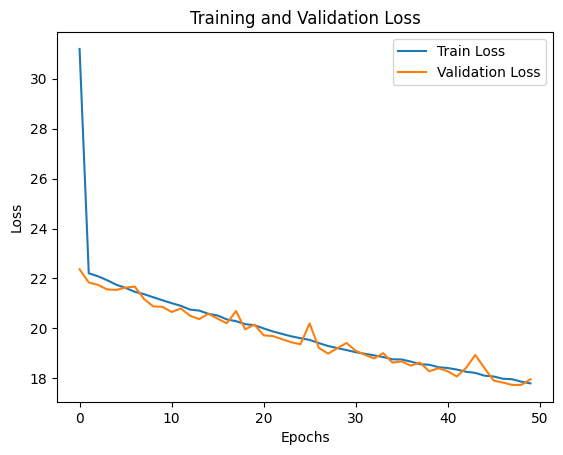

In [15]:
# 7.2 Plot training and validation losses
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [16]:
# 8. MODEL EVALUATION
model.eval()
with torch.no_grad():
    preds = model(x_test_tensor).numpy()

In [17]:
# 8.1 Calculate MSE and MAE
from sklearn.metrics import mean_absolute_error, mean_squared_error
mae = mean_absolute_error(y_test, preds)
mse = mean_squared_error(y_test, preds)
print("Mean Absolute Error: ", mae)
print("Mean Square Error: ", mse)

Mean Absolute Error:  18.44329909893589
Mean Square Error:  650.1230648165097
